In [32]:
import os
import cv2
import math
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from skimage.measure import label, regionprops
from openniftiimages import load_and_display_nifti
from scipy.spatial.distance import directed_hausdorff
from skimage.segmentation import find_boundaries, mark_boundaries

In [33]:
patient_info_file = r'G:\Annekoos Schaap - code\Data\All_imaging_features_NKI.xlsx'
base_nifti_path = r'G:\NKI dataset\Data_nifti'

# Read the patient info
patient_info_df = pd.read_excel(patient_info_file)

In [34]:
# read Excel
filename = 'coordinates_424.xlsx'
df = pd.read_excel(filename, sheet_name='Sheet1', header=None)
print(df)

print(len(df))
print(len(patient_info_df))

      0    1    2    3
0   193  199  370  298
1   137  139  342  276
2   177  197  352  292
3   153  245  352  360
4   175  195  340  316
5   173  205  332  308
6   183  171  324  270
7   161  187  346  318
8   183  201  348  306
9   175  205  348  312
10  177  199  346  334
11  141  209  360  340
12  177  225  366  338
13  143  159  362  330
14  169  189  338  302
15  193  231  346  336
16  159  203  338  310
17  157  215  350  318
18  189  231  336  312
19  175  267  342  384
20  195  233  346  352
21  187  227  342  306
22  183  221  344  320
23  161  171  384  304
24  183  245  346  326
25  173  221  352  342
26   81   92  164  146
27  188   89  387  263
28  203  183  373  331
29  303  295  410  371
30  298  276  415  355
31  284  312  415  412
32  268  262  415  382
33  309  342  401  415
34  303  295  385  371
35
35


In [35]:
dice_score_all = []
dice_score_from_jaccard_all = []
hausdorff_dist_all = []
asd_all = []
alpha_all = []

In [36]:
metrics_data = {
    'patient_name': [],
    'n_segment': [],
    'dice_score': [],
    'hausdorff_dist': [],
    'asd': [],
    'alpha': []
}

In [37]:
# Define the threshold
threshold = 0.6

In [38]:
def extract_boundary_points(mask):
    if mask.ndim != 2 or mask.size == 0:
        print("掩模形状无效:", mask.shape)
        return np.array([])  # 如果掩模不是二维或为空，则返回一个空数组

    contours = measure.find_contours(mask, level=0.5)
    points = []
    for contour in contours:
        for point in contour:
            points.append(point)
    return np.array(points)

In [39]:
def calculate_metrics(predicted_mask, prostate_mask):

    # Dice score 
    dice_score = 2 * np.sum(predicted_mask & prostate_mask) / (np.sum(predicted_mask) + np.sum(prostate_mask))

    # Jaccard index Dice score: 2 * Jaccard index / (1 + Jaccard index)
    jaccard_index = jaccard_score(prostate_mask.flatten(), predicted_mask.flatten())
    dice_score_from_jaccard = 2 * jaccard_index / (1 + jaccard_index)

    # Hausdorff distance
    u = np.transpose(np.nonzero(prostate_mask))
    v = np.transpose(np.nonzero(predicted_mask))
    hausdorff_dist = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

    print(prostate_mask.shape)
    print(predicted_mask.shape)

    return dice_score, dice_score_from_jaccard, hausdorff_dist

In [40]:
def calculate_asd(mask1, mask2):
    # 提取两个掩模的边界点
    points1 = extract_boundary_points(mask1)
    points2 = extract_boundary_points(mask2)

    print(points1.shape)
    print(points2.shape)
    
    # 计算点集之间的距离
    distances_1_to_2 = cdist(points1, points2, metric='euclidean')
    distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
    # 找到最短距离并计算平均值
    min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
    # 计算两个方向的平均表面距离
    asd_1_to_2 = np.mean(min_distances_1_to_2)
    asd_2_to_1 = np.mean(min_distances_2_to_1)
    
    # 返回双向平均表面距离
    return (asd_1_to_2 + asd_2_to_1) / 2

<Figure size 1000x1000 with 0 Axes>

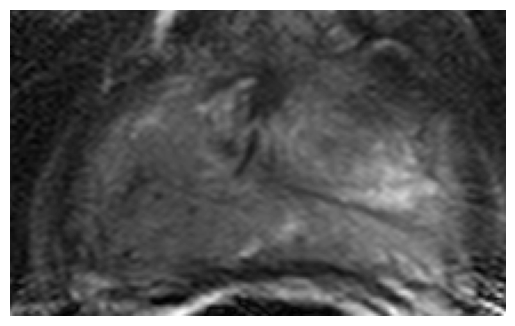

In [69]:
nifti_path = r'G:\NKI dataset\Data_nifti\MRI002\NIFTIs\T2.nii'
nifti_image = nib.load(nifti_path)
data_nifti = nifti_image.get_fdata()
image_slice = data_nifti[:, :, 9]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)

minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)

area = rescaled_image[174:308, 173:390]
# area = rescaled_image[199:298, 193:370]
plt.figure(figsize=(10, 10))
plt.figure()
plt.imshow(area, cmap='gray')
plt.axis('off')
plt.show()


# plt.imshow(rescaled_image, cmap='gray')
# plt.show()

Processing MRI002, Slice 10...
(134, 217)
Processing MRI006, Slice 12...
(172, 245)
Processing MRI008, Slice 11...
(130, 215)
Processing MRI009, Slice 12...
(150, 239)


KeyboardInterrupt: 

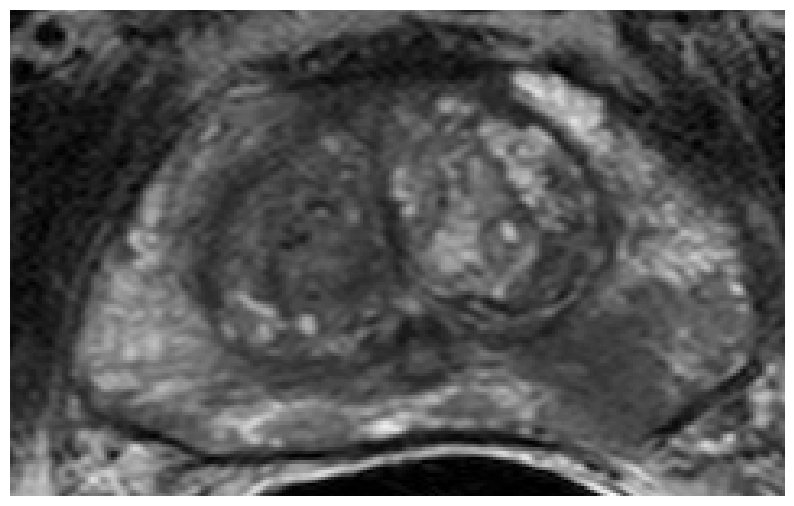

In [42]:
for index, row in patient_info_df.iterrows():
    patient_name = row['Patient name ']
    slice_no = int(np.floor(row['Slice no. ']))
    print(f"Processing {patient_name}, Slice {slice_no}...")
    nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')

    nifti_image = nib.load(nifti_path)
    data_nifti = nifti_image.get_fdata()
    
    if data_nifti.ndim == 3:
        # Get the specific slice
        image_slice = data_nifti[:, :, slice_no - 1]
            
        # Process the image slice
        image_nifti = np.rot90(image_slice, 3)
        image_nifti = np.fliplr(image_nifti)
        minni = np.min(image_nifti)
        maxni = np.max(image_nifti)
        rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
        rescaled_image = rescaled_image.astype(np.uint8)

        minX, minY, maxX, maxY = df.iloc[index, :4]
        y_min = max(minY - 25, 0)
        y_max = min(maxY + 10, rescaled_image.shape[0])
        x_min = max(minX - 20, 0)
        x_max = min(maxX + 20, rescaled_image.shape[1])
        area = rescaled_image[y_min:y_max, x_min:x_max]
        print(area.shape)

        plt.figure(figsize=(10, 10))
        plt.imshow(area, cmap='gray')
        plt.axis('off')

        save_folder = r'C:\Users\alexg\Desktop\study\graduation project\code\region'
        os.makedirs(save_folder, exist_ok=True)
        save_path = os.path.join(save_folder, f'patient_{patient_name}.png')

        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        save_path


In [ ]:
for index, row in patient_info_df.iterrows():
    for n_segment in range(20, 26, 5):
        patient_name = row['Patient name ']
        slice_no = int(np.floor(row['Slice no. ']))  # Assuming 'Slice no.' column contains integers
        print(f"Processing {patient_name}, Slice {slice_no}...")
        # Construct the path to the NIfTI file
        nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')
        
        # Load the NIfTI image
        nifti_image = nib.load(nifti_path)
        data_nifti = nifti_image.get_fdata()
        
        # Check if the number of dimensions is correct
        if data_nifti.ndim == 3:
            # Get the specific slice
            image_slice = data_nifti[:, :, slice_no]
            
            # Process the image slice
            image_nifti = np.rot90(image_slice, 3)
            minni = np.min(image_nifti)
            maxni = np.max(image_nifti)
            rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
            rescaled_image = rescaled_image.astype(np.uint8)

            # Get coordinates for the current patient
            # Assuming each patient has a corresponding row in the coordinates Excel file
            
            minX, minY, maxX, maxY = df.iloc[index, :4]
            
            # Crop the region from the rescaled image
            # Ensure that the indices do not go out of bounds
            y_min = max(minY - 25, 0)
            y_max = min(maxY + 10, rescaled_image.shape[0])
            x_min = max(minX - 20, 0)
            x_max = min(maxX + 20, rescaled_image.shape[1])
            area = rescaled_image[y_min:y_max, x_min:x_max]
            print(area.shape)

            maskpath = os.path.join(r'C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI', f'{patient_name}_{slice_no}_prostate_ROI.png')
            print(maskpath)
            image = cv2.imread(maskpath, cv2.IMREAD_GRAYSCALE)
            print(image)
            # # 将灰度图像转换为二值图像
            # _, prostate_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)  # 阈值可以根据需要调整

            # 确保 mask 是布尔类型，方便后续处理
            prostate_mask = image.astype(bool)
            
            # mat_file_path = os.path.join(base_nifti_path, 'logic_adjusted_masks', f'adjusted_patient_{patient_name}', f'adjusted_prostate_slice_{patient_name}', f'adjusted_prostate_slice_{slice_no}.mat')
            # mat = scipy.io.loadmat(mat_file_path)
            # prostate_mask = mat['logic_image']

            # y_min_1 = max(minY - 25, 0)
            # y_max_1 = min(maxY + 10, prostate_mask.shape[0])
            # x_min_1 = max(minX - 20, 0)
            # x_max_1 = min(maxX + 20, prostate_mask.shape[1])
            print(prostate_mask.shape)        
            prostate_mask = prostate_mask[y_min:y_max, x_min:x_max]

            # if prostate_mask.shape != area.shape:
            #     prostate_mask = resize(prostate_mask, area.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

            # print(prostate_mask.shape)

            pixel_amount = np.sum(prostate_mask)
            
            segments = slic(area, n_segments=n_segment, compactness=0.05, sigma=1, start_label=1, channel_axis=None)
            boundaries_1 = find_boundaries(segments, mode='inner')
            image_with_boundaries_1 = mark_boundaries(area, boundaries_1, color=(1, 0, 0))
            alpha = -math.log(n_segment/pixel_amount)

            predicted_mask = np.zeros_like(prostate_mask)
            print(area.dtype, area.shape)
            
            for region in regionprops(label(segments)):
                # Extract the superpixel region
                superpixel = (segments == region.label)
                
                # Calculate overlap with the prostate mask
                overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
                
                # If overlap exceeds the threshold, consider it as part of the prostate
                if overlap > threshold:
                    predicted_mask[superpixel] = 1

            prostate_boundaries = find_boundaries(prostate_mask, mode='inner')
            prediction_boundaries = find_boundaries(predicted_mask, mode='inner')
            print(area.dtype, area.shape)

            image_with_boundaries_2 = mark_boundaries(image_with_boundaries_1, prostate_boundaries, color=(0, 0, 1))
            image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

            plt.figure(figsize=(10, 10))
            plt.imshow(image_with_boundaries_3, cmap='gray')
            plt.axis('off')

            save_folder = r'C:\Users\alexg\Desktop\study\graduation project\code\mask_comparison424'
            os.makedirs(save_folder, exist_ok=True)
            save_path = os.path.join(save_folder, f'patient_{patient_name}_comparison_{n_segment}.png')

            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            save_path

            dice_score, dice_score_from_jaccard, hausdorff_dist = calculate_metrics(predicted_mask, prostate_mask)
            asd = calculate_asd(predicted_mask, prostate_mask)

            # dice_score_all.append(dice_score)
            # dice_score_from_jaccard_all.append(dice_score_from_jaccard)
            # hausdorff_dist_all.append(hausdorff_dist)
            # asd_all.append(asd)
            # alpha_all.append(alpha)

        metrics_data['patient_name'].append(patient_name)
        metrics_data['n_segment'].append(n_segment)
        metrics_data['dice_score'].append(dice_score)
        metrics_data['hausdorff_dist'].append(hausdorff_dist)
        metrics_data['asd'].append(asd)
        metrics_data['alpha'].append(alpha)

        print(f"Finished processing {patient_name}, Slice {slice_no}.\n")
    
print("All patients processed. Calculating metrics...")



Processing MRI002, Slice 10...
(134, 217)
C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI\MRI002_10_prostate_ROI.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(512, 512)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(1037, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI\MRI002_10_prostate_ROI.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(512, 512)
uint8 (134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(1045, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI006, Slice 12...
(172, 245)
C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI\MRI006_12_prostate_ROI.png
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0